In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from random import seed
from tqdm.notebook import tqdm


tqdm.pandas()
gc.enable()

img_size = 160 #Size of the image to rescale

random_seed = 1023
seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
DATA_DIR = "D:Dataset/dataset/hubmap-organ-segmentation/"
print(f"\n... DATA DIRECTORY PATH IS:\n\t--> {DATA_DIR}")
print(f"\n... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")): print(f"\t--> {file}")


... DATA DIRECTORY PATH IS:
	--> D:Dataset/dataset/hubmap-organ-segmentation/

... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:
	--> D:Dataset\dataset\hubmap-organ-segmentation\masked_images
	--> D:Dataset\dataset\hubmap-organ-segmentation\sample_submission.csv
	--> D:Dataset\dataset\hubmap-organ-segmentation\test.csv
	--> D:Dataset\dataset\hubmap-organ-segmentation\test_images
	--> D:Dataset\dataset\hubmap-organ-segmentation\train.csv
	--> D:Dataset\dataset\hubmap-organ-segmentation\train_annotations
	--> D:Dataset\dataset\hubmap-organ-segmentation\train_images


In [4]:
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")                                       # train_image 폴더 path
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")                                                            # train_image(key=id) 정보 csv
train_df = pd.read_csv(TRAIN_CSV)                                                                                  # train_dataframe
all_train_images = glob(os.path.join(TRAIN_IMAGES_DIR, "*.tiff"), recursive=True)   # 모든 train_image


ORGANS = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']

print("\n... ORIGINAL TRAINING DATAFRAME... \n")
display(train_df)


... ORIGINAL TRAINING DATAFRAME... 



,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [5]:
train_df["organ"].value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64

In [6]:
# 모든 image의 height와 width는 동일
print("All length is equal to all width:", np.all(train_df.img_height == train_df.img_width))

All length is equal to all width: True


In [7]:
# 추가 (image path 추가)
train_img_map = {int(x[:-5].rsplit("\\", 1)[-1]):x for x in all_train_images}
train_df.insert(3, "img_path", train_df["id"].map(train_img_map))
display(train_df)

,id,organ,data_source,img_path,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [8]:
# 제거 ()
train_df = train_df.drop(["data_source", "img_height","pixel_size","tissue_thickness","age","sex"], axis=1)
display(train_df)
gc.enable();

,id,organ,img_path,img_width,rle
0,10044,prostate,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,1459676 77 1462675 82 1465674 87 1468673 92 14...
1,10274,prostate,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,715707 2 718705 8 721703 11 724701 18 727692 3...
2,10392,spleen,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,1228631 20 1231629 24 1234624 40 1237623 47 12...
3,10488,lung,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3446519 15 3449517 17 3452514 20 3455510 24 34...
4,10610,spleen,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,478925 68 481909 87 484893 105 487863 154 4908...
...,...,...,...,...,...
346,9517,kidney,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,1611763 11 1614753 29 1617750 35 1620746 43 16...
347,9769,kidney,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3070,4030400 28 4033466 34 4036526 48 4039594 54 40...
348,9777,largeintestine,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,538473 13 541468 22 544463 30 547461 35 550459...
349,9791,kidney,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,334733 33 337729 43 340729 43 343725 51 346723...


In [9]:
# ORGANS = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
kidney_df = train_df[train_df['organ']=="kidney"]
largeintestine_df = train_df[train_df['organ']=="largeintestine"]
lung_df = train_df[train_df['organ']=="lung"]
prostate_df = train_df[train_df['organ']=="prostate"]
spleen_df = train_df[train_df['organ']=="spleen"]

In [10]:
def show_masked_img(img, mask, title="sample"):
    mask = mask *255
    plt.figure(figsize=(15,6))
    plt.subplot(131)
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(mask, cmap='coolwarm', alpha=0.5)
    plt.title(title)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(img)
    plt.imshow(mask, cmap='coolwarm', alpha=0.5)
    plt.axis("off");

In [11]:
def rle_decode(rle, width, target_size=None):
    if target_size == None:
        target_size = width
        
    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((width*width))
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1  
    label = Image.fromarray(label.reshape(width, width))
    label = label.resize((target_size, target_size))
    label = np.array(label).astype(float)
    label = np.round((label - label.min())/(label.max() - label.min()))
    return label.T

def rle_encode(mask, orig_dim=160):
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(np.float32)
    pixels = n.T.flatten()
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [12]:
def get_mask(id,shape):
    mask = train_df[train_df["id"]==id]["rle"].values
    mask = rle_decode(mask[0], shape)
    return mask

In [13]:
def get_img(id):
    img = train_df[train_df["id"]==id]["img_path"].values
    img = Image.open(img[0])
    return img

In [30]:
def get_data_with_id(id):
    size = train_df[train_df["id"]==id]["img_width"].values
    shape = (size[0], size[0])
    img = get_img(id)
    label = get_mask(id, shape)
    return img, label

In [21]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, train=False):
        self.df = df.reset_index(drop=True)
        self.dim = img_size
        self.train = train
        self.batch_size = batch_size
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def on_epoch_end(self):
        if self.train: #Reshuffle train on end of epoch
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)
            
    def __getitem__(self, idx):
        batch_x = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].id.values
        
        if not self.train:
            X = np.zeros((batch_x.shape[0], self.dim, self.dim, 3))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(f"D:Dataset/dataset/hubmap-organ-segmentation/test_images/{batch_x[i]}.tiff") # (3000,3000,3)
                image = image.resize((self.dim, self.dim)) #(180,180)
                image = np.array(image) / 255. 
                X[i,] = image  
            return X
                
        else:
            batch_y = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].rle.values
            batch_w = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].img_width.values
            
            X = np.zeros((batch_x.shape[0], self.dim, self.dim, 3))
            Y = np.zeros((batch_x.shape[0], self.dim, self.dim, 1))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(f"D:Dataset/dataset/hubmap-organ-segmentation/train_images/{batch_x[i]}.tiff")
                image = image.resize((self.dim, self.dim))
                image = np.array(image) / 255.
                rle = rle_decode(batch_y[i], batch_w[i], self.dim)
                rle = rle.reshape((self.dim, self.dim, 1))
                    
            return X, Y#.reshape(Y.shape[:-1])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 160, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 160, 160, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

 concatenate_7 (Concatenate)    (None, 160, 160, 64  0           ['conv2d_transpose_7[0][0]',     
                                )                                 'conv2d_20[0][0]']              
                                                                                                  
 dropout_15 (Dropout)           (None, 160, 160, 64  0           ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 160, 160, 32  18464       ['dropout_15[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 160, 160, 32  9248        ['conv2d_35[0][0]']              
          

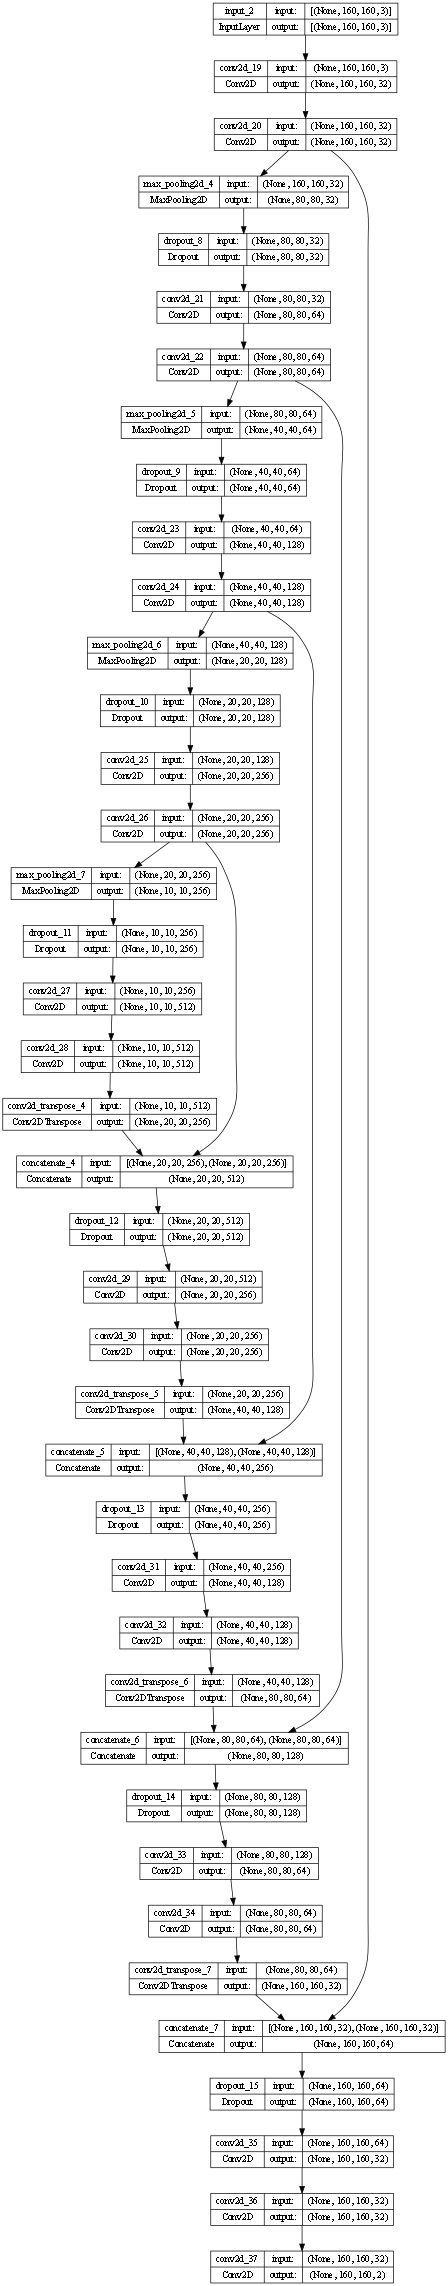

In [22]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, concatenate
from tensorflow.keras import Model

def double_conv_block(x, n_filters, step=3):
    o = Conv2D(n_filters, step, padding='same', activation='leaky_relu', kernel_initializer='he_normal')(x)
    o = Conv2D(n_filters, step, padding='same', activation='leaky_relu', kernel_initializer='he_normal')(o)
    return o

def downsample_block(x, n_filters, step=3):
    f = double_conv_block(x, n_filters, step)
    p = MaxPool2D(2)(f)
    p = Dropout(0.25)(p)
    return f, p

def upsample_block(x, conv_f, n_filters, step=3):
    o = Conv2DTranspose(n_filters, step, 2, padding='same', kernel_initializer="he_normal")(x)
    o = concatenate([o, conv_f])
    o = Dropout(0.25)(o)
    o = double_conv_block(o, n_filters, step)
    return o

def create_model(in_shape, n=32):
    s = 3
    i = Input(shape=in_shape)
    f1, p1 = downsample_block(i, n, s)
    f2, p2 = downsample_block(p1, n*2, s)
    f3, p3 = downsample_block(p2, n*2**2, s)
    f4, p4 = downsample_block(p3, n*2**3, s)
    
    bridge = double_conv_block(p4, n*2**4, s)
    
    u4 = upsample_block(bridge, f4, n*2**3, s)
    u3 = upsample_block(u4, f3, n*2**2, s)
    u2 = upsample_block(u3, f2, n*2, s)
    u1 = upsample_block(u2, f1, n, s)
    
    o = Conv2D(2, 1, padding='same', activation='softmax')(u1)
    unet = Model(inputs=i, outputs=o)
    return unet

model = create_model((img_size, img_size, 3), 32)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB', dpi=50)

In [23]:
from IPython.display import clear_output
from tensorflow.keras import backend as K

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def dice_coef(y_true, y_pred, smooth=1):
    # flatten
    y_true_f = K.flatten(K.cast(y_true, np.float32))
    #y_pred_f = K.flatten(K.cast(K.argmax(y_pred, axis=-1), np.float32))
    y_pred_f = K.flatten(K.cast(K.argmax(y_pred, axis=-1), np.float32))
    # compute numerator and denominator
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    # apply dice formula
    dice = K.mean((2.*intersection + smooth)/(union + smooth))
    return dice

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce

    # Return the mean error
    return K.mean(weighted_ce)

In [20]:
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.callbacks import ModelCheckpoint

#We will be training a model for each organ
organs = train_df.organ.unique()
epochs = 50
n_kernels = 16
batch_size = 16
print("Organs:", organs)

Organs: ['prostate' 'spleen' 'lung' 'kidney' 'largeintestine']


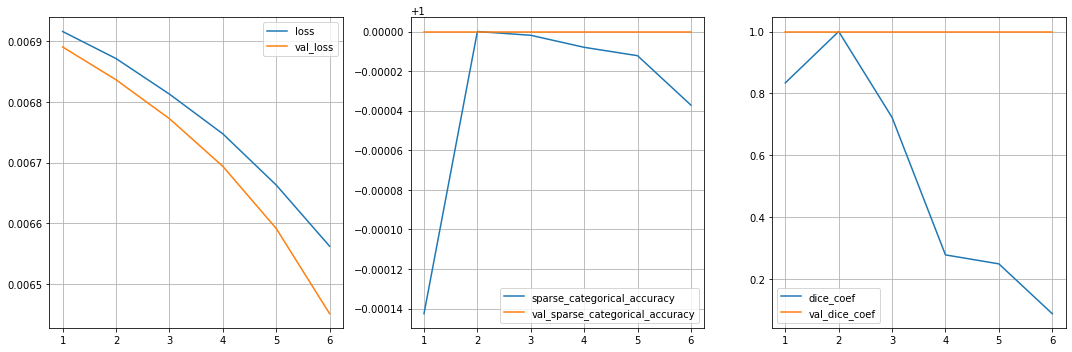


Epoch 6: val_dice_coef did not improve from 1.00000
6/6 [==============================] - 14s 2s/step - loss: 0.0066 - sparse_categorical_accuracy: 1.0000 - dice_coef: 0.0877 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 1.0000 - val_dice_coef: 1.0000
Epoch 7/50
2/6 [=========>....................] - ETA: 9s - loss: 0.0065 - sparse_categorical_accuracy: 0.9999 - dice_coef: 0.0420 

KeyboardInterrupt: 

In [295]:
organ = organs[0]
print("Training for organ:", organ)
model = create_model((img_size, img_size, 3), n_kernels)

model.compile(
    loss=weighted_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['sparse_categorical_accuracy', dice_coef],
)

mcp = ModelCheckpoint(f"{organ}_model.hdf5", monitor='val_dice_coef',
                      save_best_only=True, save_weights_only=True,
                      mode='max', verbose=True)

X = train_df[train_df.organ == organ].reset_index(drop=True)
train_X, valid_X = tts(X, test_size=0.1, shuffle=True, random_state=random_seed)
train_loader = ImageDataGenerator(train_X, batch_size, "train")
valid_loader = ImageDataGenerator(valid_X, batch_size, "train")

history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=epochs,
    callbacks=[PlotLearning(), mcp]
)

(16, 160, 160, 3) (16, 160, 160, 1)


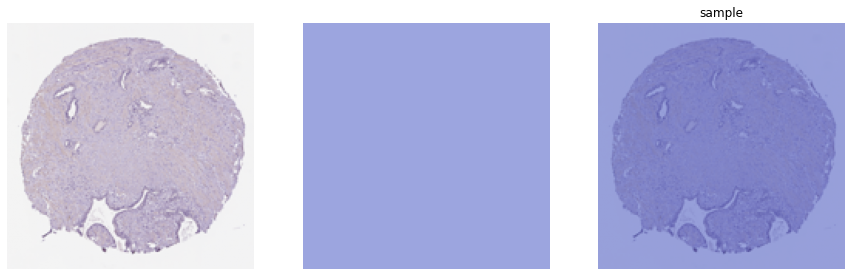

In [51]:
for x,y in train_loader:
    print(x.shape, y.shape)
    show_masked_img(x[1],y[1])
    break

In [44]:
for x,y in valid_loader:
    print(x.shape, y.shape)
    break

(16, 160, 160, 3) (16, 160, 160, 1)


In [38]:
temp

AttributeError: 'tuple' object has no attribute 'shape'

In [21]:
organ = organs[1]
print("Training for organ:", organ)
model = create_model((img_size, img_size, 3), n_kernels)
model.compile(
    loss=weighted_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.binary_accuracy, dice_coef],
)

mcp = ModelCheckpoint(f"{organ}_model.hdf5", monitor='dice_coef',
                      save_best_only=True, save_weights_only=True,
                      mode='max', verbose=True)

X = train_df[train_df.organ == organ].reset_index(drop=True)
train_X, valid_X = tts(X, test_size=0.1, shuffle=True, random_state=random_seed)
train_loader = ImageDataGenerator(train_X, batch_size, True)
valid_loader = ImageDataGenerator(valid_X, batch_size, Fase)

history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=epochs,
    use_multiprocessing=False,
    callbacks=[PlotLearning(), mcp]
)

Training for organ: spleen
Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.0050 - binary_accuracy: 0.5000 - dice_coef: 4.5888e-05

FileNotFoundError: [Errno 2] No such file or directory: 'D:Dataset/dataset/hubmap-organ-segmentation/test_images/8894.tiff'